In [1]:
import json

import gluonts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Load data

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


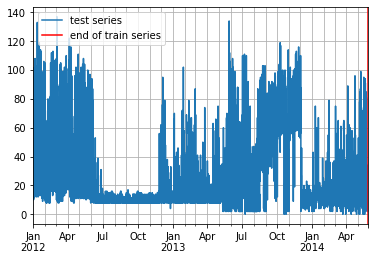

In [3]:
dataset = get_dataset("electricity", regenerate=False)

entry = next(iter(dataset.train))
train_series = to_pandas(entry)

entry = next(iter(dataset.test))
test_series = to_pandas(entry)

test_series.plot()
plt.axvline(train_series.index[-1], color="r")
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")

In [4]:
entries = []
for i, entry in enumerate(iter(dataset.train)):
  if i == 5:
    break
  entries.append(to_pandas(entry))

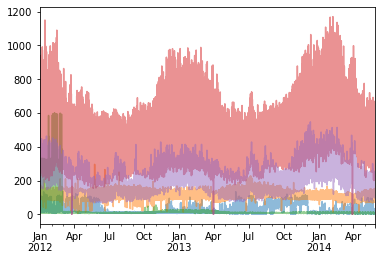

In [5]:
for entry in entries:
  entry.plot(alpha=0.5)

In [6]:
dataset.metadata

MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='321')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

# Univariate

In [7]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

In [8]:
estimator = DeepAREstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    trainer=Trainer(
        ctx="gpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [9]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:22<00:00,  4.43it/s, epoch=5/5, avg_epoch_loss=7.09]


In [10]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [11]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [12]:
forecast = list(forecast_it)
tss = list(ts_it)

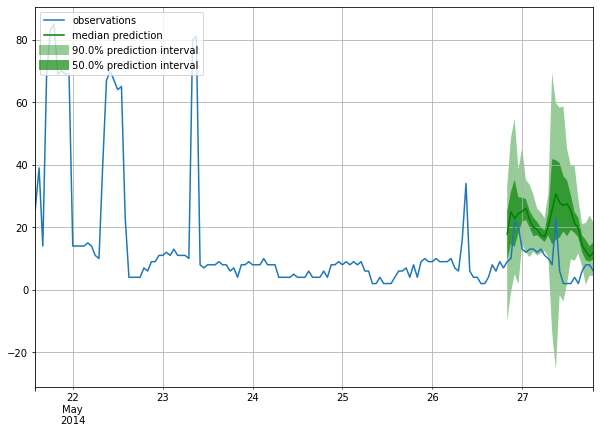

In [13]:
i = 0
forecast_entry = forecast[i]
ts_entry = tss[i]

plot_prob_forecasts(ts_entry, forecast_entry)

In [14]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
aggregated_metrics, item_metrics = evaluator(iter(tss), iter(forecast))

aggregated_metrics

Running evaluation: 2247it [00:00, 13440.52it/s]


{'MSE': 9419317.410378344,
 'abs_error': 16917846.82121849,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 1.1648128155192692,
 'MAPE': 0.12883595702045525,
 'sMAPE': 0.1364002700451529,
 'OWA': nan,
 'MSIS': 12.744777342613085,
 'QuantileLoss[0.1]': 5978125.590842684,
 'Coverage[0.1]': 0.04342827473668596,
 'QuantileLoss[0.5]': 16917846.765097663,
 'Coverage[0.5]': 0.22910176531671858,
 'QuantileLoss[0.9]': 13964665.663930463,
 'Coverage[0.9]': 0.7683021806853583,
 'RMSE': 3069.0906487717734,
 'NRMSE': 1.2866836435521563,
 'ND': 0.13152031444584458,
 'wQuantileLoss[0.1]': 0.046474292255576276,
 'wQuantileLoss[0.5]': 0.13152031400955805,
 'wQuantileLoss[0.9]': 0.10856211423712026,
 'mean_wQuantileLoss': 0.09551890683408486,
 'MAE_Coverage': 0.1530559264204124}

# Multivariate

In [15]:
from gluonts.model.gpvar import GPVAREstimator
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

In [16]:
dim = 5
grouper = MultivariateGrouper(max_target_dim=dim)

In [17]:
dataset_multi_train = grouper(dataset.train)
dataset_multi_test = grouper(dataset.test)

In [18]:
estimator_multi = DeepVAREstimator(
        target_dim=dim,
        prediction_length=dataset.metadata.prediction_length,
        freq="H",
        trainer=Trainer(
            ctx="gpu",
            epochs=50,
            learning_rate=1e-3,
        )
    )

In [19]:
pred_multi = estimator_multi.train(dataset_multi_train)

100%|██████████| 50/50 [00:09<00:00,  5.00it/s, epoch=50/50, avg_epoch_loss=26.9]


In [20]:
forecast_it_multi, ts_it_multi = make_evaluation_predictions(
    dataset=dataset_multi_test,
    predictor=pred_multi,
    num_samples=100,
)

In [21]:
forecast_multi = list(forecast_it_multi)
tss_multi = list(ts_it_multi)

In [22]:
forecast_multi[0].samples.shape, tss_multi[0].values.shape

((100, 24, 5), (21212, 5))

In [23]:
def plot_multi_prob_forecasts(ts_entry, forecast_entries):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    for entry in forecast_entries:
      entry.plot(prediction_intervals=prediction_intervals, color='g')
      
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [24]:
from copy import deepcopy

i = 0
ts_entry = tss_multi[i]
forecast_entry = forecast_multi[i]

forecast_entry1 = deepcopy(forecast_entry)
forecast_entry2 = deepcopy(forecast_entry)
forecast_entry3 = deepcopy(forecast_entry)
forecast_entry4 = deepcopy(forecast_entry)
forecast_entry5 = deepcopy(forecast_entry)
forecast_entry1.samples = forecast_entry.samples[:, :, 0]
forecast_entry2.samples = forecast_entry.samples[:, :, 1]
forecast_entry3.samples = forecast_entry.samples[:, :, 2]
forecast_entry4.samples = forecast_entry.samples[:, :, 3]
forecast_entry5.samples = forecast_entry.samples[:, :, 4]

forecast_entries = [forecast_entry1, forecast_entry2, forecast_entry3, forecast_entry4, forecast_entry5]

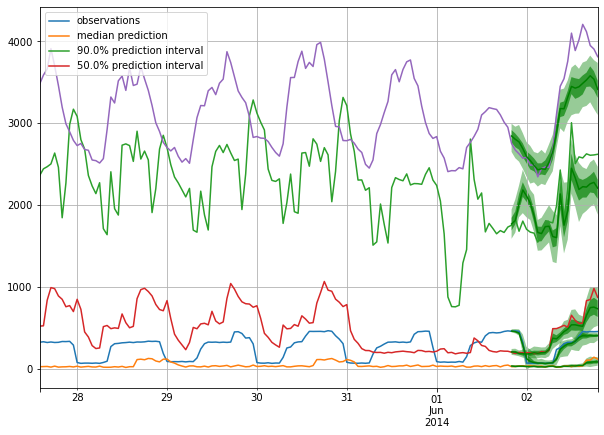

In [25]:
plot_multi_prob_forecasts(ts_entry, forecast_entries)